In [2]:
PATH = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/"
from modules.learning.models import *
from modules.learning.train import train_model
from modules.utils import hc
from modules.visualize import plot_loss, plot_normalized_time_error

# from modules.learning.evaluate import Evaluation, get_latent_space, plot_umap
from matplotlib import pyplot as plt
from modules.learning.dycep import DYCEP
import json
from types import SimpleNamespace


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# enet = EfficientNet()


track_path = PATH + "track_datasets/control_mm/train/images/"
label_path = PATH + "track_datasets/control_mm/train/labels/"

in_channels = [1]


expandable_segments:True


In [3]:
config_numbers = [17, 19, 21]
t_encoders = []

configs = []

for i,n in enumerate(config_numbers):
    conf_path = f"weights/config-{n}.json"
    with open(conf_path, "r") as file:
        config = json.load(file)
    configg = SimpleNamespace(**config)

    configs.append(configg)
    t_encoders.append(config['temporal_encoder'])
    

LSTM
TransformerEncoder
Mamba


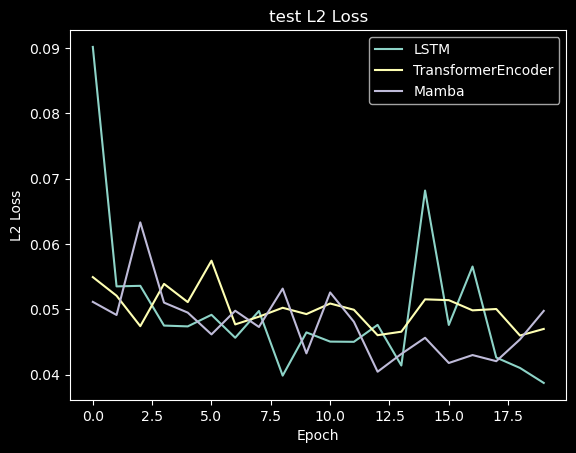

In [4]:
t_encoders

for i,en in enumerate(t_encoders):
    print(en)

    plt.title(f"test L2 Loss")
    plt.plot(configs[i].test_loss, label=en)
    # plt.plot(config["train_loss"], label="train")

    plt.legend()

    plt.ylabel("L2 Loss")
    plt.xlabel("Epoch")

In [5]:
from types import SimpleNamespace

configg = SimpleNamespace(**config)

In [6]:
temporal_encoder_dim = 256
temporal_encoder_layers = 6 

def pick_t_encoder(string):
    if string == "Mamba":
        from modules.learning.time_encoders.mamba import Mamba, MambaConfig

        temporal_encoder = Mamba(
            MambaConfig(
                temporal_encoder_dim, temporal_encoder_layers, d_state=16
            )
        )
    elif string == "TransformerEncoder":
        temporal_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=temporal_encoder_dim,
                nhead=8,
                dim_feedforward=temporal_encoder_dim * 2,
                batch_first=True,
            ),
            num_layers=temporal_encoder_layers - 1,
        )
    elif string == "LSTM":
        temporal_encoder = nn.LSTM(
            input_size=256,
            hidden_size=256,
            num_layers=6,
            batch_first=True,
            bidirectional=False,
        )
    return temporal_encoder


In [7]:
from modules.learning.evaluate import Evaluation

2024-12-12 12:57:09.923736: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 12:57:10.547585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
eval_subpath = "track_datasets/control_mm/test/"

models = []
full_track_evals = []

for i, c_n in enumerate(config_numbers):

    print(configs[i].temporal_encoder)

    temporal_encoder = pick_t_encoder(configs[i].temporal_encoder)

    model = DYCEP(
    cnn_in_channels=len(in_channels), temporal_encoder=temporal_encoder
    );
    model.to(DEVICE);

    model.load_state_dict(torch.load(f"weights/model-{c_n}.pt"))

    eval = Evaluation()
    eval.fit(
        PATH + eval_subpath, model, img_channels=in_channels, smoothing=True
    )

    full_track_evals.append(eval)
    models.append(model)

LSTM


100%|██████████| 358/358 [00:07<00:00, 45.69it/s]


TransformerEncoder


100%|██████████| 358/358 [00:05<00:00, 68.80it/s]


Mamba


100%|██████████| 358/358 [00:07<00:00, 45.95it/s]


In [9]:
metrics = ['\ell_1', '\ell_2', 'W_d', 'Accuracy']

for i, t_e in enumerate(t_encoders):
    print(t_e)
    print(full_track_evals[i].summary())

LSTM
----------------------------------------------------------------------
Model Performance:
\ell_1: 0.074 ± 0.030
\ell_2: 0.017 ± 0.020
W_d: 0.055 ± 0.020
Accuracy: 0.888 ± 0.073

TransformerEncoder
----------------------------------------------------------------------
Model Performance:
\ell_1: 0.079 ± 0.035
\ell_2: 0.019 ± 0.021
W_d: 0.056 ± 0.018
Accuracy: 0.871 ± 0.090

Mamba
----------------------------------------------------------------------
Model Performance:
\ell_1: 0.074 ± 0.031
\ell_2: 0.016 ± 0.020
W_d: 0.057 ± 0.022
Accuracy: 0.887 ± 0.083



Mamba
----------------------------------------------------------------------
Model Performance:
\ell_1: 0.074 ± 0.031
\ell_2: 0.016 ± 0.020
W_d: 0.057 ± 0.022
Accuracy: 0.887 ± 0.083



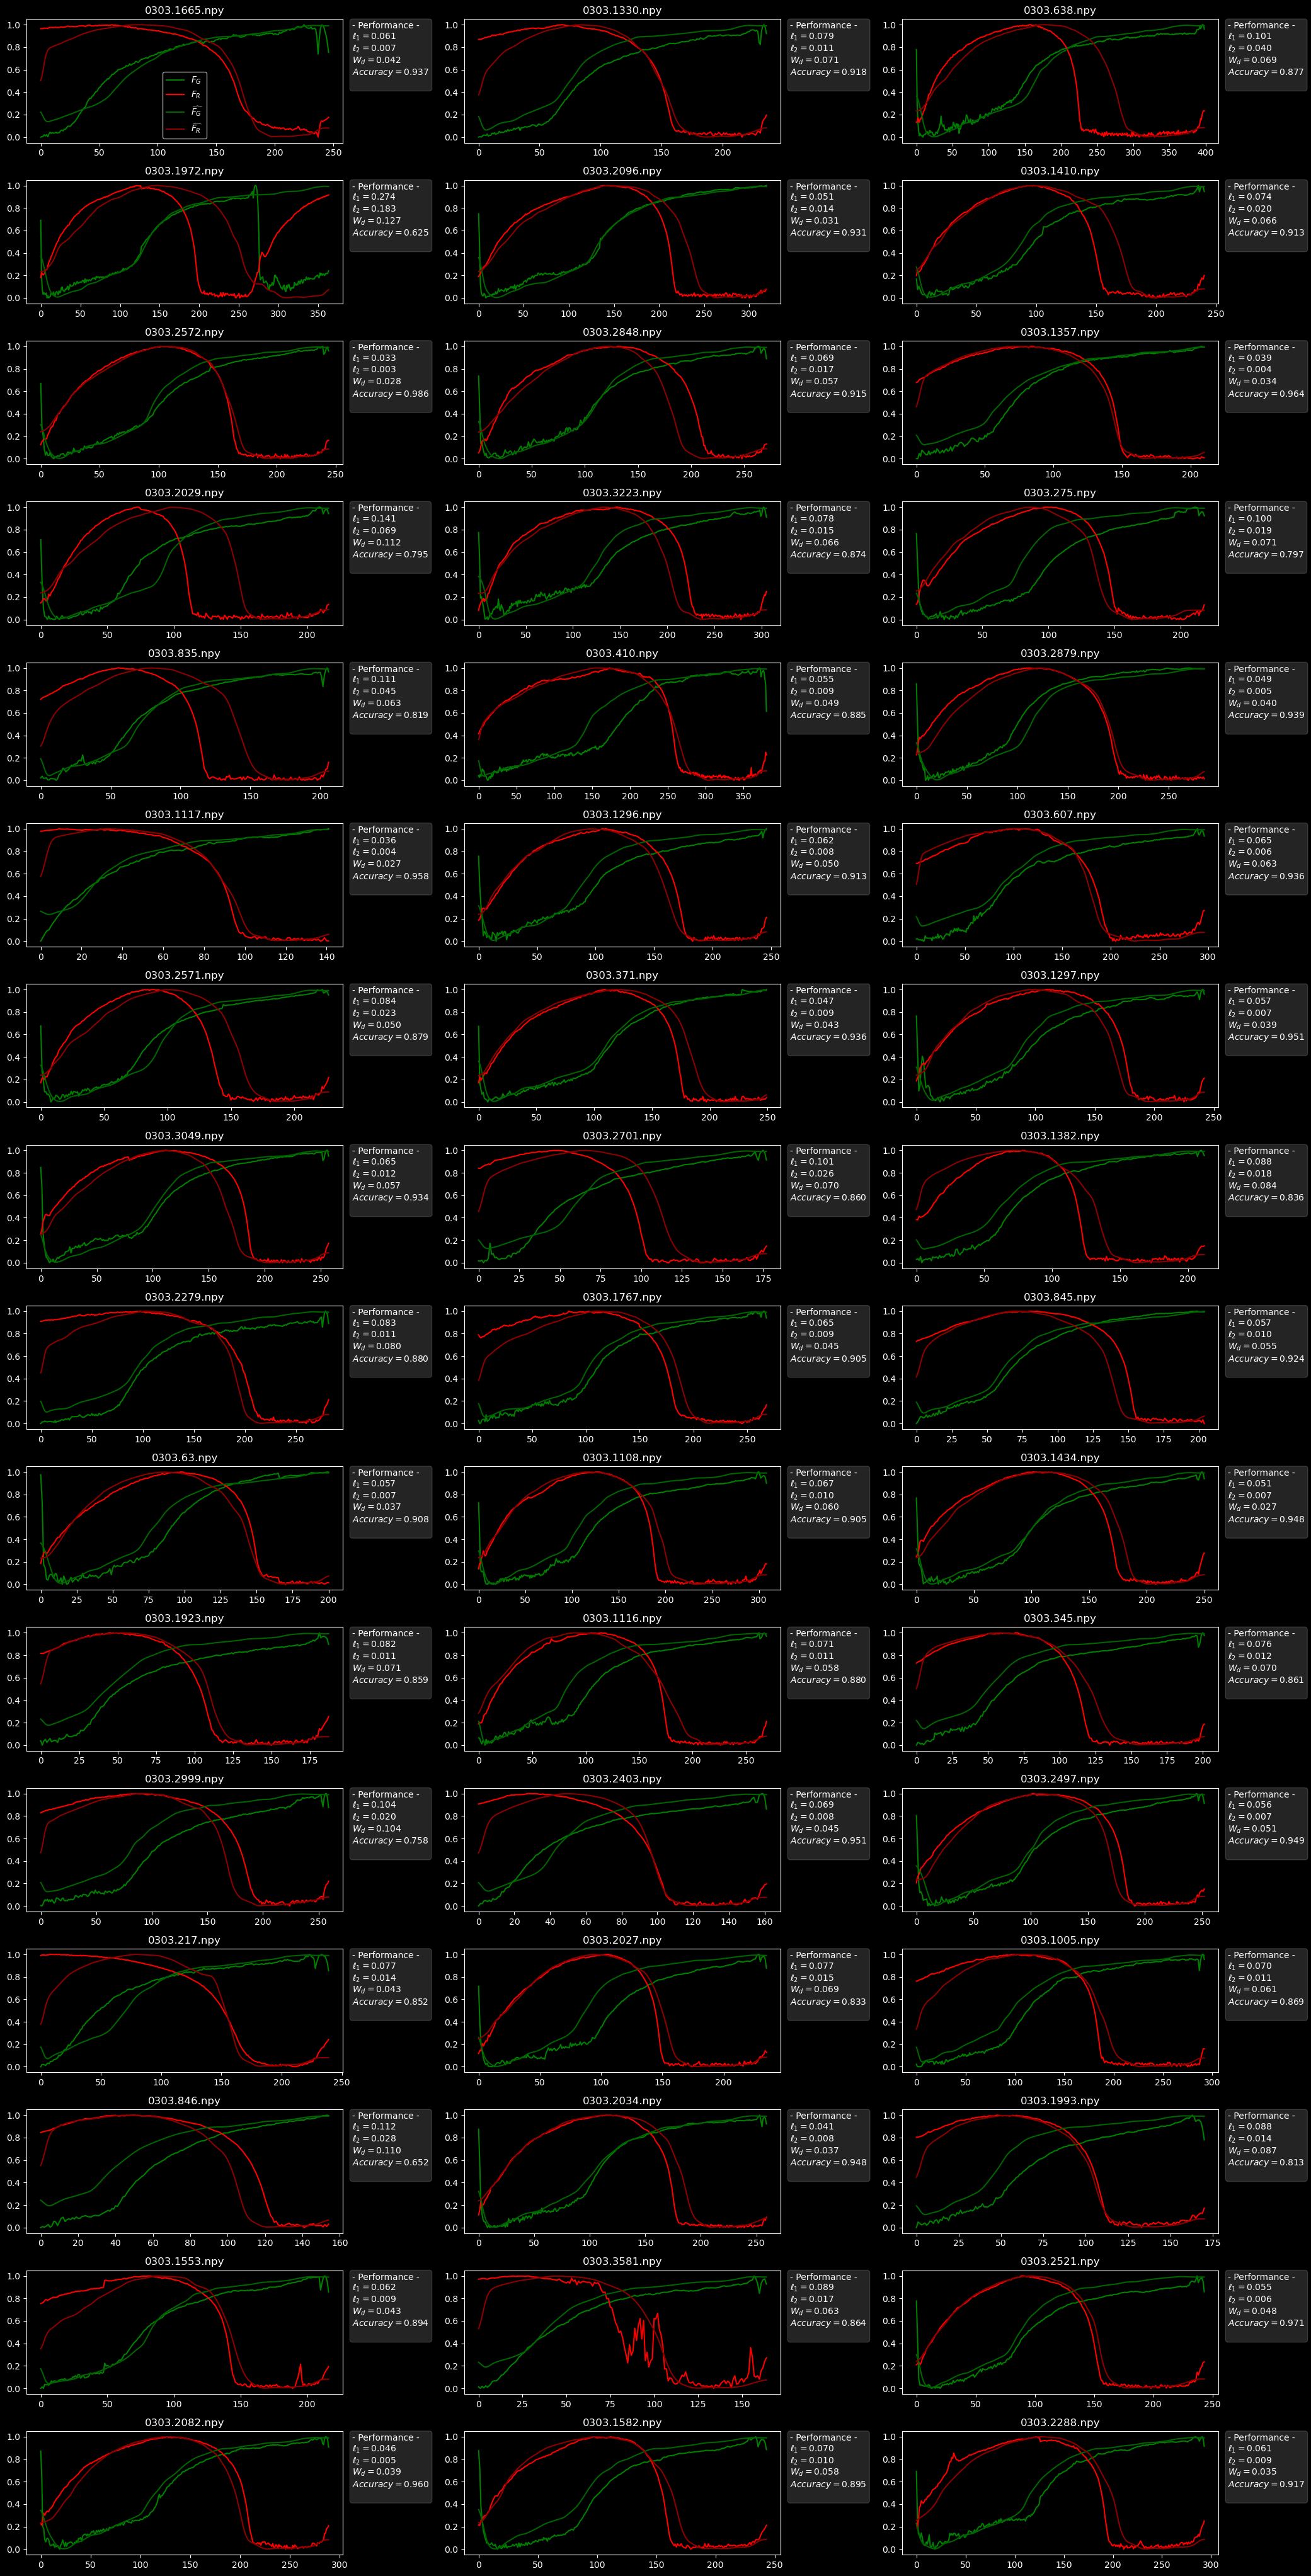

In [10]:
print(model.temporal_encoder.__class__.__name__)

print(eval.summary())

eval.visualize_predicted_tracks(50)

In [11]:
eval.prediction_df.columns

Index(['CELL_ID', 'y', 'y_hat', '\ell_1', '\ell_2', 'W_d', 'Accuracy'], dtype='object')

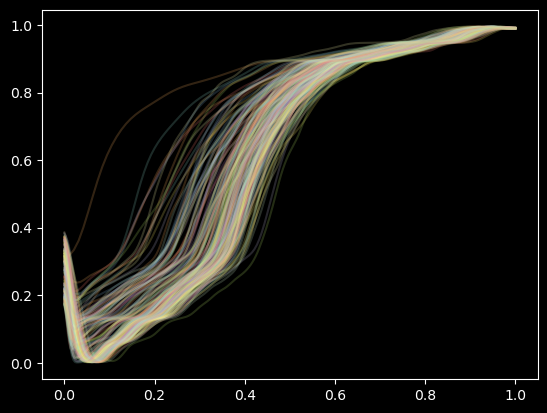

In [12]:
for i in range(200):
    track = eval.prediction_df.y_hat[i]
    tau = np.linspace(0, 1, track.shape[0])
    plt.plot(tau, track[:, 0], alpha=0.2)

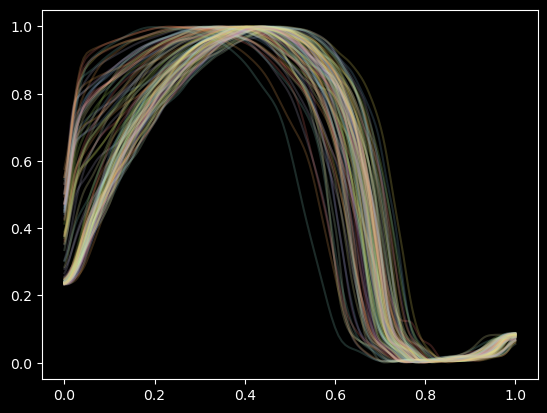

In [13]:
for i in range(100):
    track = eval.prediction_df.y_hat[i]
    tau = np.linspace(0, 1, track.shape[0])
    plt.plot(tau, track[:, 1], alpha=0.2)

# get phases + partial tracks

In [14]:
import os
from tqdm import tqdm

In [15]:
img_directory = PATH + "track_datasets/control_mm/test/images/"
label_directory = PATH + "track_datasets/control_mm/test/labels/"
cells = os.listdir(img_directory)[:]

In [16]:
len(cells)

# integer numbers from 1 to len(cells) as random seeds
rand_seeds = np.array(range(len(cells)))
rand_seeds;

In [17]:
slice_p = 1.
random_len = True
slice_len = 10

# this is a copied and adapted function that gets random slices from the sequnces
# 

def random_slice(imgs, labels, random_len=True, min_len=2, seed=None):

    if seed is not None:
        np.random.seed(seed)

    if random_len:
        slice_len = np.random.randint(min_len, labels.shape[0] - 1)
    x = np.random.randint(0, labels.shape[0] - slice_len)

    print(x, slice_len)

    return (
        imgs[x : x + slice_len],
        labels[x : x + slice_len],
    )  # minimum 2h of images


random_slice

<function __main__.random_slice(imgs, labels, random_len=True, min_len=2, seed=None)>

In [18]:


slice_len = np.random.randint(2, 300 - 1)
x = np.random.randint(0, 300 - slice_len)

print(x, slice_len)

140 136


In [22]:
from modules.utils import nd_wasserstein, tolerance_accuracy

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    ConfusionMatrixDisplay,
)

metric_functions = {
    "\ell_1": mean_absolute_error,
    "\ell_2": mean_squared_error,
    "W_d": nd_wasserstein,
    "Accuracy": tolerance_accuracy,
}

# for metric, function in metric_functions.items():
#     print(function)
#     print(function(label[0], prediction[0])
# )


In [23]:
img_directory = PATH + "track_datasets/control_mm/test/images/"
label_directory = PATH + "track_datasets/control_mm/test/labels/"
cells = os.listdir(img_directory)[:]
# Initialize pandas cells so we can store tracks inside
# model.to(DEVICE)

ph = []
imgs = []
labels = []
prediction = []
for idx, cell in enumerate(tqdm(cells)):
    # Get input with specific image channels and groundtruth FUCCI signal
    x = (
        torch.tensor(
            np.load(img_directory + cell, allow_pickle=True),
            dtype=torch.float32,
        )[:, [1], :, :]
        .to(DEVICE)
    )
    lab = np.load(label_directory + cell).reshape(2, -1).T


    if np.random.rand() < slice_p and lab.shape[0] > slice_len:
        x, lab = random_slice(x, lab, seed=rand_seeds[idx])

    # imgs.append(x.detach().cpu().numpy().squeeze())
    imgs.append(x)
    labels.append(lab)

    # x = model.spatial_encoder(x.unsqueeze(0))
    # x = model.temporal_encoder(model.fc_s2t(x))
    # if model.temporal_encoder.__class__.__name__ == "LSTM":
    #     x = x[0]
    # x = model.get_phi(x)
    # pred = model.vanilla_fn(x)

    # ph.append(x.detach().cpu().numpy().squeeze())
    # label.append(lab)
    # prediction.append(pred.detach().cpu().numpy().squeeze())

 19%|█▉        | 69/358 [00:00<00:00, 342.09it/s]

47 174
140 39
15 170
131 154
174 124
118 101
73 140
68 177
4 197
54 128
36 267
63 155
3 77
10 340
88 109
0 135
69 171
143 113
19 44
110 95
15 101
15 203
4 119
102 85
87 194
62 134
62 55
72 21
5 259
34 215
45 39
23 212
133 45
135 22
21 124
15 203
98 135
76 145
211 55
9 139
7 221
4 165
51 104
64 70
163 22
124 133
5 191
134 137
51 2
13 172
0 178
16 59
11 158
29 27
69 113
39 156
143 87
5 216
23 34
44 179
1 207
18 101
24 20
116 46
38 198
63 48
316 22
53 69
28 204
203 56
24 216


 41%|████      | 145/358 [00:00<00:00, 364.13it/s]

173 109
14 277
2 148
9 160
19 114
0 137
4 217
22 199
74 191
60 177
65 69
66 133
23 84
49 172
32 108
44 150
13 232
0 218
30 149
14 180
42 124
11 167
2 189
41 152
90 86
163 92
180 44
35 131
280 10
11 353
78 2
9 265
142 71
22 194
90 112
176 64
23 101
245 8
61 130
22 214
65 102
92 167
19 76
91 146
59 311
0 240
15 258
34 196
0 169
85 68
62 189
66 111
28 208
2 191
202 113
60 203
19 212
40 97
21 155
12 224
58 99
8 163
6 229
59 161
22 135
38 224
69 119
12 6
80 106
49 120
197 23
17 80
60 105
81 157
8 216


 63%|██████▎   | 226/358 [00:00<00:00, 383.96it/s]

19 85
28 51
50 27
29 220
1 201
156 97
116 87
0 256
63 46
19 170
14 159
95 13
129 106
51 80
18 333
142 99
2 122
34 194
57 7
10 67
57 215
49 37
36 41
48 191
66 171
13 30
165 47
84 22
68 66
36 51
29 184
23 155
22 243
1 219
122 63
129 39
7 274
65 2
30 175
30 109
65 60
64 65
12 80
3 179
121 100
38 240
22 148
25 293
72 30
0 275
71 256
54 166
105 28
41 2
60 153
133 110
13 67
36 68
210 23
50 8
68 200
1 224
103 12
70 8
190 63
32 230
97 119
229 16
15 25
60 148
102 79
1 254
92 117
102 78
45 136
190 19
61 158
32 165
138 66
104 34


 87%|████████▋ | 312/358 [00:00<00:00, 404.31it/s]

115 146
112 170
0 2
176 89
30 7
113 41
31 202
94 154
34 131
66 65
110 37
12 170
20 145
144 92
103 144
136 28
43 55
30 166
88 129
3 256
27 225
1 347
102 157
62 183
41 72
169 53
2 162
22 136
1 201
57 106
143 12
26 226
14 207
35 125
19 176
159 55
87 52
52 182
9 177
26 126
72 34
64 107
11 244
2 241
66 116
58 89
12 164
66 97
29 162
40 51
89 39
86 118
50 123
71 145
64 75
8 163
5 207
143 45
9 164
4 177
6 238
1 49
62 174
1 220
19 226
35 86
48 136
80 158
10 220
33 211
146 70
35 96
124 61
202 33
23 171
81 27
91 119
2 185
20 265
1 126
56 194
20 162
170 10


100%|██████████| 358/358 [00:00<00:00, 376.51it/s]

109 10
9 101
96 89
2 249
112 76
111 35
194 271
124 28
73 162
38 186
12 155
9 187
76 155
1 197
178 86
105 148
0 223
25 182
104 49
12 238
18 132
17 251
201 30
66 6
69 81
71 120
34 134
101 117
187 21
113 65
71 119
208 26
187 22
0 179
8 85
31 191
86 125
98 68
102 68
11 127
6 174
2 256
55 64
57 170


In [24]:
prediction = {}
ph = {}


for i, t_e in enumerate(t_encoders):
    print(t_e)

    model = models[i]

    prediction[t_e] = []
    ph[t_e] = []

    for idx, cell in enumerate(tqdm(cells)):
        
        x = imgs[idx]
        lab = labels[idx]

        x = model.spatial_encoder(x.unsqueeze(0))
        x = model.temporal_encoder(model.fc_s2t(x))
        if model.temporal_encoder.__class__.__name__ == "LSTM":
            x = x[0]
        x = model.get_phi(x)
        pred = model.vanilla_fn(x)

        ph[t_e].append(x.detach().cpu().numpy().squeeze())
        prediction[t_e].append(pred.detach().cpu().numpy().squeeze())

        # ph.append(x.detach().cpu().numpy().squeeze())
        # label.append(lab)
        # prediction.append(pred.detach().cpu().numpy().squeeze())

LSTM


100%|██████████| 358/358 [00:04<00:00, 87.99it/s] 


TransformerEncoder


100%|██████████| 358/358 [00:02<00:00, 155.10it/s]


Mamba


100%|██████████| 358/358 [00:03<00:00, 96.02it/s] 


In [26]:
pred_dfs = {}

import pandas as pd

for i, t_e in enumerate(t_encoders):

    print(t_e)

    pred_dfs[t_e] = pd.DataFrame(
        columns=["\ell_1", "\ell_2", "W_d", "Accuracy"]
    )

    for idx, cell in enumerate(cells):

        label = labels[idx]
        pred = prediction[t_e][idx]

        for metric, function in metric_functions.items():
            print(function(labels[idx], prediction[t_e][idx]))
            pred_dfs[t_e].loc[idx, metric] = function(label, pred)

LSTM
0.12113569461825471
0.030661616960736278
0.10207130798496498
0.7155172413793104
0.12284007011690282
0.02948687129843588
0.11941423624892569
0.782051282051282
0.3341076132191057
0.20771442682089367
0.2896050544486455
0.47941176470588237
0.15186644868378313
0.06122117941680846
0.09215914864095623
0.7077922077922078
0.28634695475108657
0.17969477120633742
0.2658875337840687
0.5443548387096774
0.253286979594473
0.14619267330905755
0.23750835694874978
0.5891089108910891
0.0627613257640484
0.006745011696974199
0.04758745050670328
0.9392857142857143
0.124168510644636
0.03138103246397257
0.11873243648853876
0.672316384180791
0.04877691380434384
0.0069106457393859205
0.04391916382211361
0.9213197969543148
0.1203023058694962
0.0402774954479266
0.11215154215202824
0.8671875
0.06522298855800746
0.006965774034095812
0.06332747792387301
0.9307116104868914
0.12908177328360254
0.044578803353019614
0.08580589086608632
0.7419354838709677
0.43769604521801225
0.2845633226283528
0.3942957311959201
0.2

In [27]:
for i, t_e in enumerate(t_encoders):
    print(t_e)

    for metric in metrics:
        
        print(f"{metric}: {pred_dfs[t_e][metric].mean():.3f} \u00B1 {pred_dfs[t_e][metric].std():.3f}")

LSTM
\ell_1: 0.201 ± 0.138
\ell_2: 0.105 ± 0.111
W_d: 0.182 ± 0.135
Accuracy: 0.639 ± 0.243
TransformerEncoder
\ell_1: 0.217 ± 0.129
\ell_2: 0.115 ± 0.106
W_d: 0.192 ± 0.129
Accuracy: 0.603 ± 0.208
Mamba
\ell_1: 0.214 ± 0.172
\ell_2: 0.118 ± 0.142
W_d: 0.195 ± 0.167
Accuracy: 0.625 ± 0.284


In [158]:
# get evaluation metrics
import pandas as pd

prediction_df = pd.DataFrame()
prediction_df["CELL_ID"] = cells

for i in range(len(label)):
    for metric, function in metric_functions.items():
        prediction_df.loc[i, metric] = function(label[i], prediction[i])

In [149]:
ph0 = [p[0] for p in ph]
ph_fn = [p[-1] for p in ph]

print(f"ph 0 mean {np.mean(ph0)} std {np.std(ph0)}")
print(f"ph fin mean {np.mean(ph_fn)} std {np.std(ph_fn)}")
print(f"ph 0 min {np.min(ph0)} max {np.max(ph0)}")
print(f"ph fin min {np.min(ph_fn)} max {np.max(ph_fn)}")


ph 0 mean 0.008180522359907627 std 0.014207622967660427
ph fin mean 0.9732629656791687 std 0.026264332234859467
ph 0 min 0.004589291289448738 max 0.15912948548793793
ph fin min 0.7347365617752075 max 0.9806218147277832


Text(0.5, 0, 'Normalized Time')

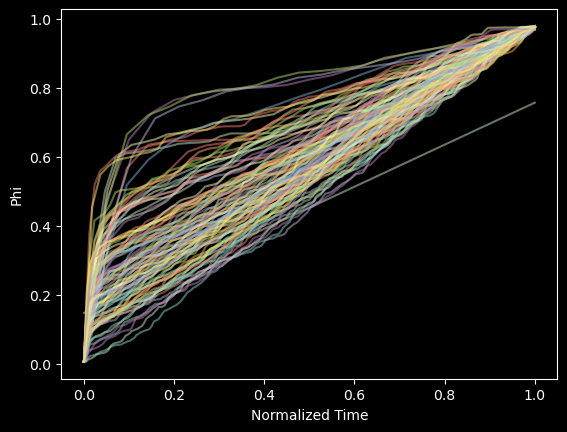

In [140]:
for i in range(100):
    plt.plot(np.linspace(0, 1, len(ph[i])), ph[i], alpha=0.5)

plt.ylabel("Phi")
plt.xlabel("Normalized Time")

KeyError: 0

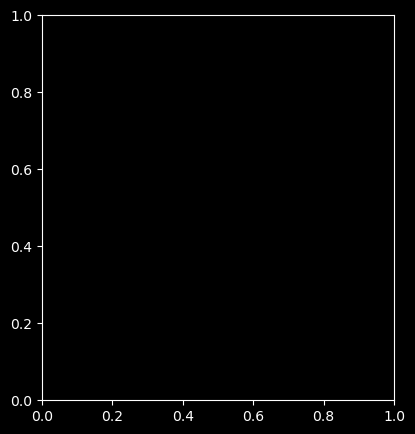

In [28]:
for i in range(15):
    tau = np.linspace(0, 1, len(labels[i]))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)

    plt.plot(prediction[i][:,0], "darkgreen", labels="prediction")
    plt.plot(labels[i][:,0], "green",  label="groundtruth")
    plt.plot(prediction[i][:,1], "darkred", label="prediction")
    plt.plot(labels[i][:,1], "red",  label="groundtruth")

    plt.legend()

    # plt.subplot(1, 2, 2)

    # plt.plot(ph[i], prediction[i][:,0], "darkgreen", label="prediction")
    # plt.plot(tau, label[i][:,0], "green",  label="groundtruth")
    # plt.plot(ph[i], prediction[i][:,1], "darkred", label="prediction")
    # plt.plot(tau, label[i][:,1], "red",  label="groundtruth")


    # plt.legend()
    # plt.show()